<a href="https://colab.research.google.com/github/greg881203/-/blob/main/peoplecounting1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import h5py
import os
import glob
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
root = 'mc2_dataset'
part_A_train = os.path.join(root,'train','images')
part_A_test = os.path.join(root,'test','images')

path_sets = [part_A_train]
print(path_sets)

img_paths = []

for path in path_sets:

    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(str(img_path))

print("Total images : ", len(img_paths))

['mc2_dataset/train/images']
Total images :  243


In [3]:
def create_img(path):
    # Function to load,normalize and return image
    im = Image.open(path).convert('RGB')

    im = np.array(im)

    im = im / 255.0

    im[:, :, 0] = (im[:, :, 0] - 0.485) / 0.229
    im[:, :, 1] = (im[:, :, 1] - 0.456) / 0.224
    im[:, :, 2] = (im[:, :, 2] - 0.406) / 0.225

    # print(im.shape)
    # im = np.expand_dims(im,axis  = 0)
    return im


def get_input(path):
    path = path[0]
    img = create_img(path)
    return (img)


def get_output(path):
    # import target
    # resize target

    gt_file = h5py.File(path, 'r')

    ground_truth_density_map = np.asarray(gt_file['density'])
    scale_size = 16
    flag1 = (ground_truth_density_map.shape[1] % scale_size) != 0
    flag2 = (ground_truth_density_map.shape[0] % scale_size) != 0

    if flag1:
        t_shape1 = (ground_truth_density_map.shape[1] // scale_size) + 1
    else:
        t_shape1 = ground_truth_density_map.shape[1] // scale_size

    if flag2:
        t_shape2 = (ground_truth_density_map.shape[0] // scale_size) + 1
    else:
        t_shape2 = ground_truth_density_map.shape[0] // scale_size
    ground_truth_density_map = cv2.resize(ground_truth_density_map, (t_shape1, t_shape2), interpolation=cv2.INTER_CUBIC) * (scale_size**2)

    ground_truth_density_map = np.expand_dims(ground_truth_density_map, axis = -1)

    # print(img.shape)

    return ground_truth_density_map



In [4]:
# Image data generator
def image_generator(files, batch_size=1):
    while True:
        input_path = np.random.choice(a=files, size=batch_size)

        batch_input = []
        batch_output = []

        # for input_path in batch_paths:

        inputt = get_input(input_path)
        output = get_output(input_path[0].replace('.jpg', '.h5').replace('images', 'ground_truth'))

        batch_input += [inputt]
        batch_output += [output]

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield (batch_x, batch_y)

In [5]:
# def image_generator(files, batch_size=1):
#     num_files = len(files)
#     file_index = 0

#     while True:
#         batch_input = []
#         batch_output = []

#         for _ in range(batch_size):
#             input_path = files[file_index]

#             inputt = get_input(input_path)
#             output = get_output(input_path.replace('.jpg', '.h5').replace('images', 'ground_truth'))

#             batch_input.append(inputt)
#             batch_output.append(output)

#             file_index = (file_index + 1) % num_files

#         batch_x = np.array(batch_input)
#         batch_y = np.array(batch_output)

#         # yield (batch_x, batch_y)

In [6]:
img_input = Input(shape=(1080, 1920, 3))

# 使用MobileNetV2作為特徵提取層
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

x = mobilenetv2.layers[115].output
# x = mobilenetv2.layers[115].output
# 10753
x = Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2,groups=96,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2, groups=96,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=2, groups=192,activation='relu')(x)


# 最後輸出density map
density_map = Conv2D(filters=1, kernel_size=1,name='density_map')(x)

# 建立模型
model = Model(img_input, density_map)
# model.summary()



In [7]:
from keras import backend as K
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function)
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [8]:
l_rate = 1e-3
# decay = 5 * 1e-4
import tensorflow as tf
train_gen = image_generator(img_paths,1)
optimizer = tf.optimizers.Adam(learning_rate=l_rate)
# model.compile(optimizer= optimizer, loss=euclidean_distance_loss, metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit_generator(train_gen,epochs=5,steps_per_epoch=243 , verbose=1)

<ipython-input-8-53cd77134139>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen,epochs=5,steps_per_epoch=243 , verbose=1)


Epoch 1/5
243/243 [==============================] - 60s 129ms/step - loss: 1.4106e-05
Epoch 2/5
243/243 [==============================] - 33s 137ms/step - loss: 1.4045e-05
Epoch 3/5
243/243 [==============================] - 32s 133ms/step - loss: 1.3962e-05
Epoch 4/5
243/243 [==============================] - 34s 141ms/step - loss: 1.3451e-05
Epoch 5/5
243/243 [==============================] - 33s 136ms/step - loss: 1.3135e-05


In [9]:
def save_mod(model, str1, str2):
    model.save_weights(str1)

    model_json = model.to_json()

    with open(str2, "w") as json_file:
        json_file.write(model_json)

save_mod(model,"weights/model_A_weights.h5","models/Model.json")

In [10]:
def load_model():
    # Function to load and return neural network model
    json_file = open('models/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/model_A_weights.h5")
    return loaded_model

def create_img(path):
    #Function to load,normalize and return image
    print(path)
    im = Image.open(path).convert('RGB')

    im = np.array(im)

    im = im/255.0

    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [11]:
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    model = load_model()
    image = create_img(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

In [12]:
from keras.models import model_from_json
ans,img,hmap = predict('mc2_dataset/train/images/1.jpg')

mc2_dataset/train/images/1.jpg
1/1 [==============================] - 1s 1s/step


1.4992323
[[[[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]

  [[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]

  [[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]

  ...

  [[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]

  [[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]

  [[0.00018373]
   [0.00018373]
   [0.00018373]
   ...
   [0.00018373]
   [0.00018373]
   [0.00018373]]]]


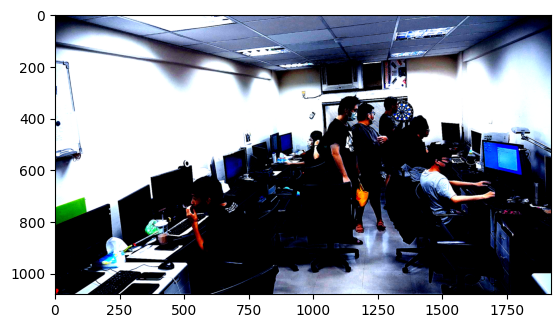

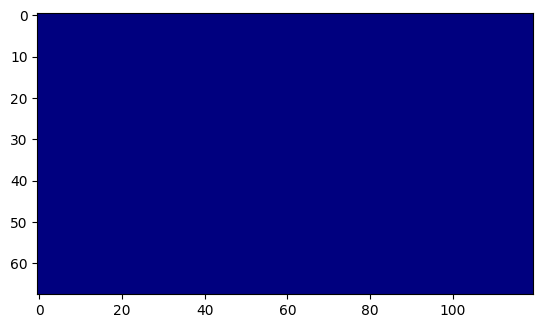

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm as c
print(ans)
#Print count, image, heat map
print(hmap)
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

Original Count :  7


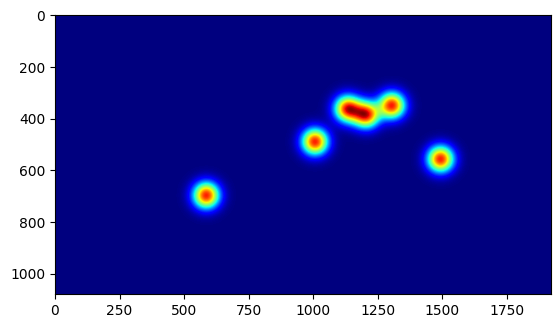

In [14]:
temp = h5py.File('mc2_dataset/train/ground_truth/1.h5' , 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)